In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2

from PIL import Image

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

import time
import datetime

2025-05-21 17:34:22.224442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [3]:
data = []
labels = []

image_dir = "train/"
csv_path = "train/train_metadata.csv"

# Load the CSV that contains filenames and labels
df = pd.read_csv(csv_path)

for index, row in df.iterrows():
    try:
        img_path = os.path.join(image_dir, row['image_path'])
        image = Image.open(img_path)
        image = image.resize((30, 30))
        image = np.array(image)
        data.append(image)
        labels.append(row['ClassId'])
    except Exception as e:
        print(f"Error loading image {row['image_path']}: {e}")


In [4]:
data = np.array(data)
labels = np.array(labels)

In [5]:
print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(5488, 30, 30, 3) (5488,)
(4390, 30, 30, 3) (1098, 30, 30, 3) (4390,) (1098,)


In [6]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(43, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#M odel display
model.summary() 

2025-05-21 17:34:33.756739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-21 17:34:33.756898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        51264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         295168    
                                                        

In [7]:
epochs = 35
history1 = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/35


2025-05-21 17:34:35.863345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-21 17:34:36.027907: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


35/35 [==============================] - ETA: 0s - loss: 7.8624 - accuracy: 0.0738

2025-05-21 17:34:40.788193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 6s 123ms/step - loss: 7.8624 - accuracy: 0.0738 - val_loss: 3.5006 - val_accuracy: 0.1175
Epoch 2/35
35/35 [==============================] - 3s 87ms/step - loss: 3.3030 - accuracy: 0.1911 - val_loss: 2.5170 - val_accuracy: 0.3898
Epoch 3/35
35/35 [==============================] - 3s 93ms/step - loss: 2.6656 - accuracy: 0.3866 - val_loss: 1.6173 - val_accuracy: 0.5965
Epoch 4/35
35/35 [==============================] - 3s 97ms/step - loss: 2.0671 - accuracy: 0.5285 - val_loss: 1.1357 - val_accuracy: 0.6876
Epoch 5/35
35/35 [==============================] - 4s 100ms/step - loss: 1.7419 - accuracy: 0.6175 - val_loss: 0.9952 - val_accuracy: 0.7486
Epoch 6/35
35/35 [==============================] - 3s 95ms/step - loss: 1.5610 - accuracy: 0.6795 - val_loss: 0.9130 - val_accuracy: 0.7842
Epoch 7/35
35/35 [==============================] - 4s 107ms/step - loss: 1.4919 - accuracy: 0.7134 - val_loss: 0.6738 - val_accuracy: 0.8033
Epoch 8/35
35/35 [===

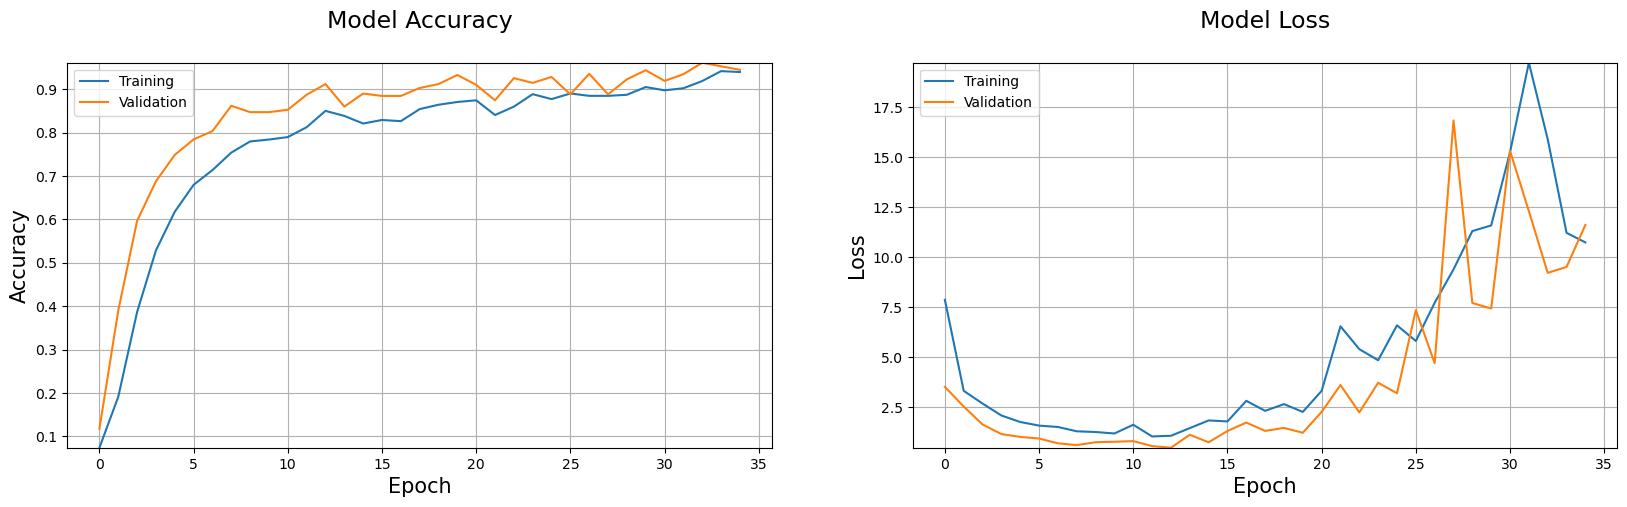

In [8]:
plot_performance(history=history1)

 5/35 [===>..........................] - ETA: 0s

2025-05-21 17:36:45.272401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 1s 9ms/step


<Figure size 2500x2500 with 0 Axes>

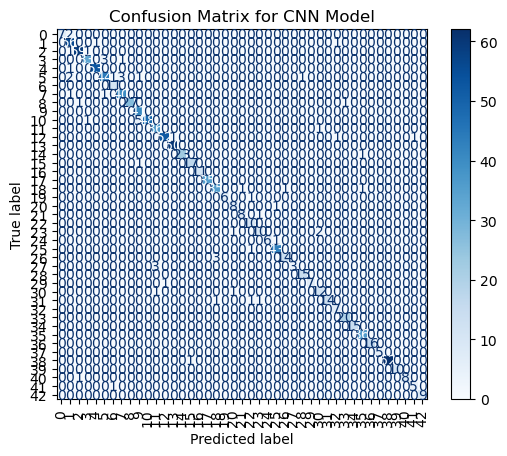

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay


y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # predicted class IDs
y_true_classes = np.argmax(y_test, axis=1)        # true class IDs

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Step 3: Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(25, 25))
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix for CNN Model")
plt.show()

35/35 [==============================] - 0s 6ms/step


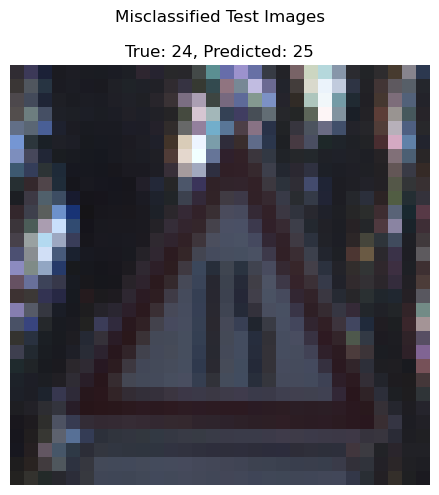

In [10]:
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

num_to_display = 1
plt.figure(figsize=(10, 5))

for i, idx in enumerate(misclassified_indices[:num_to_display]):
    plt.subplot(1, num_to_display, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {y_true_classes[idx]}, Predicted: {y_pred_classes[idx]}")
    plt.axis('off')

plt.suptitle("Misclassified Test Images")
plt.tight_layout()
plt.show()


In [11]:
test_csv_path = "test/test_metadata.csv"
test_image_dir = "test/"
output_csv_path = "test/predictions.csv"

# Load test metadata
test_df = pd.read_csv(test_csv_path)

# Extract image paths and IDs
image_paths = test_df["image_path"].values
ids = test_df["id"].values
data = []

# Load and preprocess each image
for img_file in image_paths:
    try:
        img_path = os.path.join(test_image_dir, img_file)
        image = Image.open(img_path)
        image = image.resize((30, 30))
        image = np.array(image)
        data.append(image)
    except Exception as e:
        print(f"Error loading image {img_file}: {e}")
        data.append(np.zeros((30, 30, 3))) 

X_test = np.array(data)

# Predict class labels
pred_labels = np.argmax(model.predict(X_test), axis=-1)

# Create new DataFrame with only id and predicted ClassId
predictions_df = pd.DataFrame({
    "id": ids,
    "ClassId": pred_labels
})

# Save to new CSV
predictions_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to: {output_csv_path}")

74/74 [==============================] - 1s 8ms/step
Predictions saved to: test/predictions.csv
